# Telco Customer Churn
Focused customer retention programs
## Context
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
## Content
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

Customers who left within the last month – the column is called Churn
Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
Demographic info about customers – gender, age range, and if they have partners and dependents
## Inspiration
To explore this type of models and learn more about the subject.

[Page on kaggle](https://www.kaggle.com/blastchar/telco-customer-churn)

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

from category_encoders import WOEEncoder, SumEncoder, OrdinalEncoder

from scipy.stats import mannwhitneyu

# Exploratory analysis

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.shape)

(7043, 21)


In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [5]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', '0').astype('float64')

No     5174
Yes    1869
Name: Churn, dtype: int64


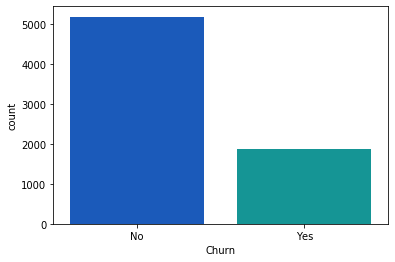

In [6]:
print(df['Churn'].value_counts())
sns.countplot('Churn', data=df, palette='winter')
plt.show()

Let's build histograms for categorical variables.

In [7]:
def build_histograms(data, features):
    n_rows = (len(features) + 1) // 2
    fig, axs = plt.subplots(n_rows, 2, figsize=(16, n_rows*6))
    fig.subplots_adjust(hspace=0.4)
    for feature, ax in zip(features, axs.flatten()):
        sns.countplot(feature, hue='Churn', data=data, palette='muted', ax=ax)

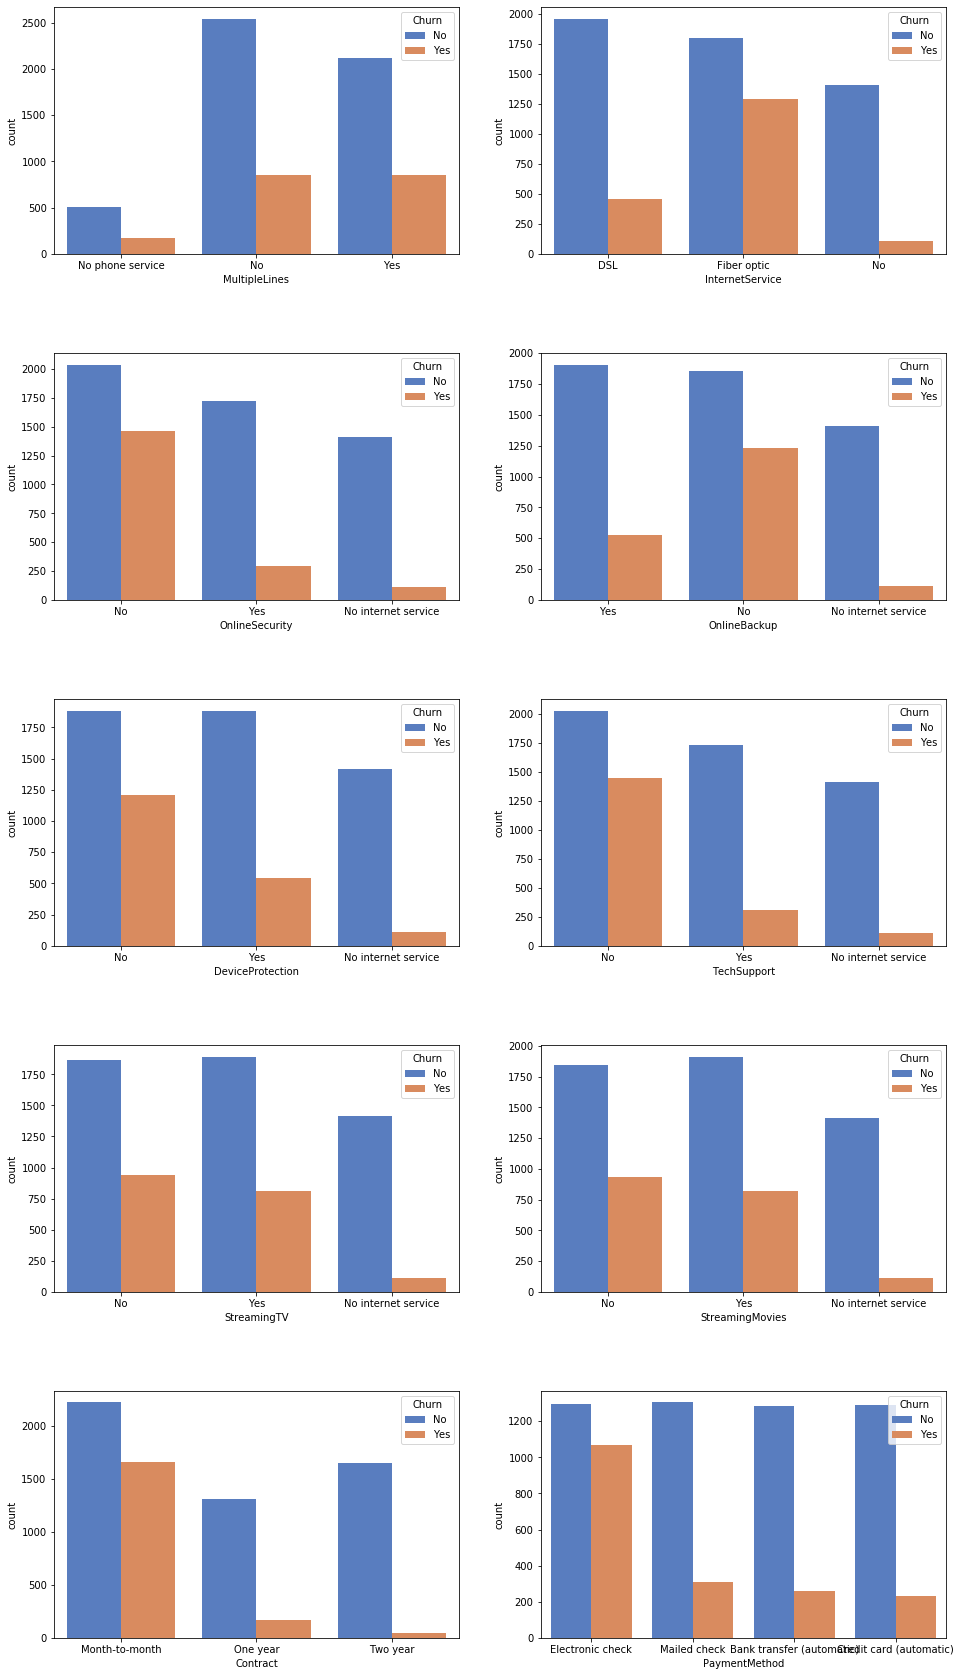

In [8]:
cat_features = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
build_histograms(df, cat_features)

Look at binary variables.

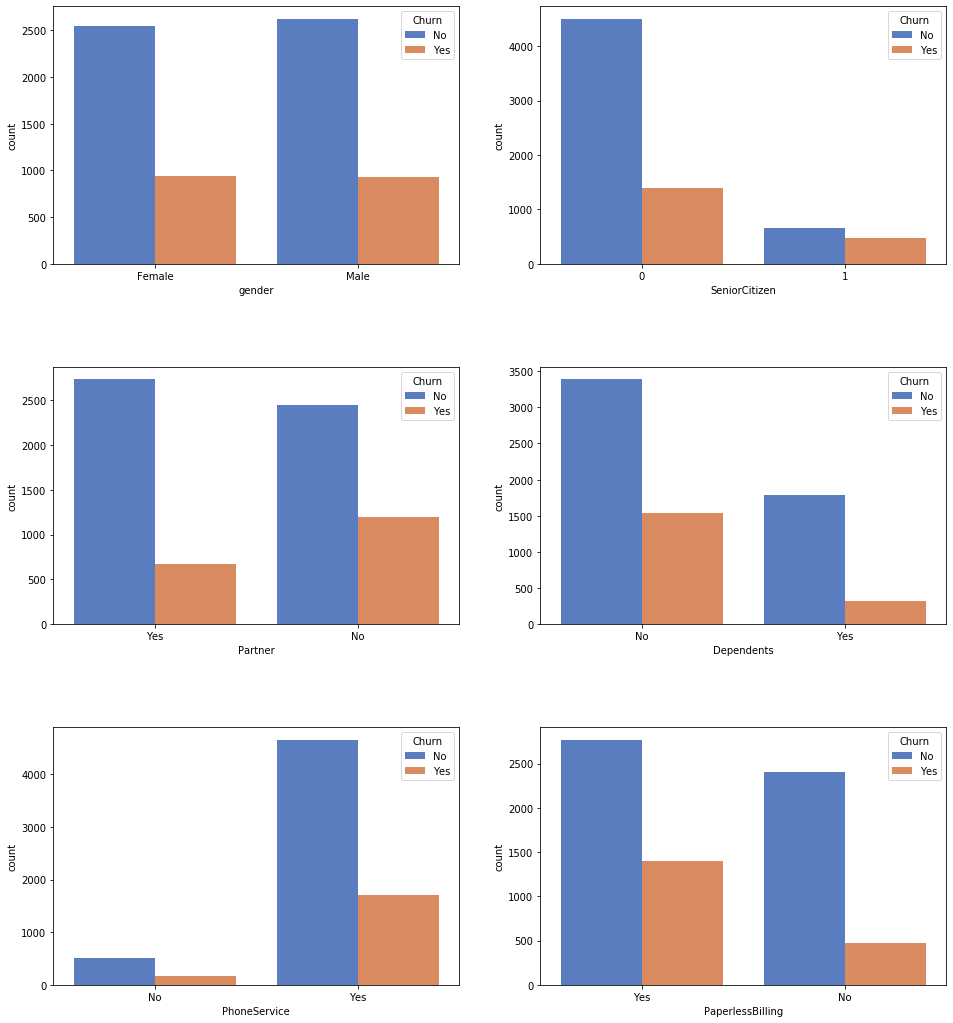

In [9]:
bin_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

build_histograms(df, bin_features)

Observe the numeric features.

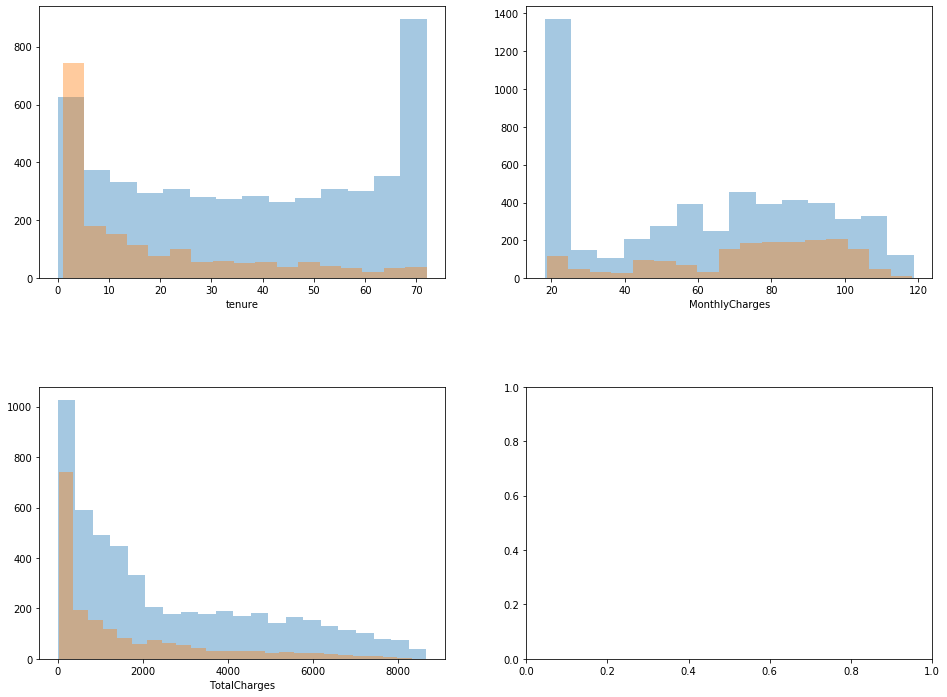

In [10]:
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

n_rows = (len(num_features) + 1) // 2
fig, axs = plt.subplots(n_rows, 2, figsize=(16, n_rows*6))
fig.subplots_adjust(hspace=0.4)
for feature, ax in zip(num_features, axs.flatten()):
    sns.distplot(df[df['Churn'] == 'No'][feature], ax=ax, kde=False)
    sns.distplot(df[df['Churn'] == 'Yes'][feature], ax=ax, kde=False)

Compute the Mann-Whitney rank test on churn and not churn samples.

In [11]:
for feature in num_features:
    print(mannwhitneyu(df[df['Churn'] == 'No'][feature],
                       df[df['Churn'] == 'Yes'][feature]))

MannwhitneyuResult(statistic=2515538.0, pvalue=1.209817758975933e-208)
MannwhitneyuResult(statistic=3667080.5, pvalue=1.6558138259942924e-54)
MannwhitneyuResult(statistic=3381224.0, pvalue=2.842516933103657e-83)


### Summary
1. The dataset has 7043 observations and 21 features.
1. The dataset is unbalanced.
1. Customers who have fiber optic internet service and do not have online security, online backup, device protection, tech support are more likely to churn.
1. Cutomers with month-to-month contract, paperless billing and electronic check are more likely to churn.
1. Senior citizens who have not partner or not dependents are more likey to churn.
1. According to histograms, customers with tenure < 5 months are likely to churn. But Mann-Whitney U test says that all numeric features are significant.

### To do
1. All the columns make sense except 'customerID' – should be dropped.
1. Numerical features shoud be normalized in case of using a linear model.
1. 'TotalCharges' has missing data. The missing data should be changed to 0.
1. The next features should be casted to boolean: gender, SeniorCitizen, Partner, Dependents, PhoneService, PaperlessBilling

# Data cleaning

Split data to train and holdout.

In [12]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
X_train, X_holdout, y_train, y_holdout = train_test_split(df.drop('Churn', axis='columns'),
                                                          df['Churn'],
                                                          test_size=0.2,
                                                          stratify=df['Churn'])
X_train.shape, X_holdout.shape, y_train.shape, y_holdout.shape

((5634, 20), (1409, 20), (5634,), (1409,))

Delete duplicate observations.

In [13]:
df_train_drop_duplicates = pd.concat([X_train, y_train], axis='columns').drop_duplicates()
X_train = df_train_drop_duplicates.drop('Churn', axis='columns')
y_train = df_train_drop_duplicates['Churn']
X_train.shape, y_train.shape

((5634, 20), (5634,))

There is no duplicates.

Handle numeric features. Transform 'TotalCharges' feature to float64.

In [14]:
class CustomNumericTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['TotalCharges'] = X['TotalCharges'].replace(' ', '0').astype('float64')
        return X


num_transformer = Pipeline([('custom', CustomNumericTransformer()),
                            ('scaler', StandardScaler())])

Handle categorical features. Use OneHotEncoder for baseline.

In [15]:
cat_transformer = Pipeline([('encoder', OneHotEncoder())])

Handle binary features. Transform every feature individually.

In [16]:
class CustomBinaryTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['gender'] = X['gender'].map({'Male': 1, 'Female': 0})
        for feature in ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']:
            X[feature] = X[feature].map({'Yes': 1, 'No': 0})
        return X


bin_transformer = Pipeline([('custom', CustomBinaryTransformer())])

Bring all pipelines together.

In [17]:
preprocessor = ColumnTransformer([('num', num_transformer, num_features),
                                  ('cat', cat_transformer, cat_features),
                                  ('bin', bin_transformer, bin_features)])

## Baseline

Build the baselines for logistic regression, random forest and gradient boosting. The target metric is ROC AUC.

In [18]:
cross_val_scores = []
for estimator in [LogisticRegression(class_weight='balanced'),
                  RandomForestClassifier(class_weight='balanced'),
                  GradientBoostingClassifier()]:
    pipe = Pipeline([('preprocessor', preprocessor),
                     ('estimator', estimator)])
    score = cross_val_score(pipe,
                            X_train,
                            y_train,
                            scoring='roc_auc',
                            n_jobs=-1)
    cross_val_scores.append(score.mean())
print('Logistic Regression:', cross_val_scores[0])
print('Random Forest:', cross_val_scores[1])
print('Gradient Boosting:', cross_val_scores[2])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Logistic Regression: 0.8456353296059884
Random Forest: 0.7997276112456726
Gradient Boosting: 0.8472809925606214


Logistic regression and gradient boosting show the same perforamnce in cross validation. Let's check all models with holdout dataset.

In [19]:
holdout_scores = []
for estimator in [LogisticRegression(class_weight='balanced'),
                  RandomForestClassifier(class_weight='balanced'),
                  GradientBoostingClassifier()]:
    pipe = Pipeline([('preprocessor', preprocessor),
                     ('estimator', estimator)])
    pipe.fit(X_train, y_train)
    score = roc_auc_score(y_holdout, pipe.predict_proba(X_holdout)[:, 1])
    holdout_scores.append(score)
print('Logistic Regression:', holdout_scores[0])
print('Random Forest:', holdout_scores[1])
print('Gradient Boosting:', holdout_scores[2])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Logistic Regression: 0.839443023586246
Random Forest: 0.7875429486682683
Gradient Boosting: 0.8435686791185513


Gradient boosting is better in both cross validation and holdout test.

In [20]:
grad_boost_pipe = Pipeline([('preprocessor', preprocessor),
                            ('estimator', GradientBoostingClassifier())])

## Fitting parameters

Finding the best categorical feature encoder.

In [24]:
encoder_scores = []
encoders = [WOEEncoder(), OneHotEncoder(), SumEncoder(), OrdinalEncoder()]
for encoder in encoders:
    preprocessor = ColumnTransformer([('num', num_transformer, num_features),
                                      ('cat', encoder, cat_features),
                                      ('bin', bin_transformer, bin_features)])
    grad_boost_pipe = Pipeline([('preprocessor', preprocessor),
                                ('estimator', GradientBoostingClassifier())])
    score = cross_val_score(grad_boost_pipe,
                            X_train,
                            y_train,
                            scoring='roc_auc',
                            n_jobs=-1)
    encoder_scores.append(score.mean())
for encoder, score in zip(encoders, encoder_scores):
    print(type(encoder).__name__ + ':', score)
print('The best is:', type(encoders[np.argmax(encoder_scores)]).__name__)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warni

WOEEncoder: 0.8471866346159787
OneHotEncoder: 0.847317126581534
SumEncoder: 0.8472450731370498
OrdinalEncoder: 0.8465999607391356
The best is: OneHotEncoder


In [26]:
preprocessor = ColumnTransformer([('num', num_transformer, num_features),
                                  ('cat', OneHotEncoder(), cat_features),
                                  ('bin', bin_transformer, bin_features)])
grad_boost_pipe = Pipeline([('preprocessor', preprocessor),
                            ('estimator', GradientBoostingClassifier())])

Select the best boosting parameters.

In [38]:
param_grid = {'estimator__learning_rate': [0.01, 0.02, 0.025],
              'estimator__n_estimators': [100, 200, 300],
              'estimator__max_depth': [3, 4, 5],
              'estimator__max_features': ['auto', None],
              'estimator__subsample': [0.3, 0.5, 1]}
grid = GridSearchCV(grad_boost_pipe,
                    param_grid,
                    scoring='roc_auc',
                    n_jobs=-1,
                    cv=3,
                    verbose=20)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:  2.3min
[Paralle

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  4.2min
[Paralle

[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  6.1min
[Paralle

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('custom',
                                                                                          CustomNumericTransformer()),
                                                                                         ('scaler',
                                          

In [39]:
grid.best_score_, grid.best_params_

(0.8500917461201574,
 {'estimator__learning_rate': 0.025,
  'estimator__max_depth': 3,
  'estimator__max_features': None,
  'estimator__n_estimators': 200,
  'estimator__subsample': 0.5})

Fit the best estimator and check it with holdout.

In [43]:
roc_auc_score(y_holdout, grid.best_estimator_.predict_proba(X_holdout)[:, 1])

0.8449830788705469

In [46]:
grad_boost_pipe = Pipeline([('preprocessor', preprocessor),
                            ('estimator', GradientBoostingClassifier(learning_rate=0.025,
                                                                     n_estimators=200,
                                                                     subsample=0.5))])
grad_boost_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('custom',
                                                                   CustomNumericTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                

In [48]:
roc_auc_score(y_holdout, grad_boost_pipe.predict_proba(X_holdout)[:, 1])

0.8449365780567827